#### Киселев Алексей

# Обучение модели UNET+RESNET_50 
## Отборочный этап стажировки в Лаборатории Машинного Обучения МФТИ

## Отчет

Краткие итоги работы:
    Цель работы - предложить модель, сегментирующую человека на фотографии.
    Использованная нейросеть для обучения - Unet на предобученной модели ResNet50.
    Результаты исследования - точность на валидационной выборке 97% по метрике DiseLoss.

Структурные кластеры анализа, значимые для высокого качества предсказания:
    1) выбор модели;
    2) выбор лостфункций и метрик для лучшего обучения;
    3) проведение аугментации на тренировочном датасете.

Выбор модели.
        
Ввиду достаточно сложной задачи для сегментации (большое количество мелких деталей на ряде изображений) сразу была осознана необходимость использования глубоких сетей. Важно было выбрать такую модель, которая максимально не склонна к переобучению. На необходимость этого указывало относительно небольшое количество как тренировочных, так и валидационных изображений (даже несмотря на возможность применения аугментации). 

ResNet - глубокая нейронная сеть. В отличие от ряда предшествующих моделей (в частности VGG), устойчива к переобучению при увеличении числа слоев в модели. Такой эффект достигается за счет «остаточной» структуры обучения, при которой модель может пропускать слои, тем самым снижая вероятность переобучения. Соединения быстрого доступа( Shortcut Connections) пропускают несколько слоев  и выполняют сопоставление идентификаторов. Их выходы добавляются к выходам stacked layers.[1]

Источник[1]: https://neurohive.io/ru/vidy-nejrosetej/resnet-34-50-101/

Кроме вышеперечисленных преимуществ, она хорошо зарекомендовала себя на практике, и что наиболее важно, демонстрирует высокую точность обучения при добавлении архитектуры сверточной сети U-Net. Такая комбинация длинных и коротких пропускаемых соединений позволяет еще больше калебровать точность модели, что доказывает перечень проведенных измерений.[2]

Источник[2]: https://medium.com/datadriveninvestor/review-u-net-resnet-the-importance-of-long-short-skip-connections-biomedical-image-ccbf8061ff43

Положенная в основу данного исследования архитектура U-net изначально применялась в биологии для распознавания изображений при очень ограниченном объеме обучающих выборок. Фактически U-net является комбинацией сверхточной сети (то есть сети в процессе обучения уменьшающей разрешение изображения, но при этом увеличивая многоканальную глубину). Данная сеть обучается методом стохастического градиентного спуска на основе входных изображений и соответствующих им карт сегментации. На первом этапе (этап кодировки) картинка сжимается, на втором (этап декодера) изображение расширяется в маску и сравнивается с соответствующей текущему слою картинкой из предыдущих слоев. [3] 

Источник[3]: https://arxiv.org/pdf/1505.04597.pdf

Важной особенностью Unet, как и других сверхточных сетей, является переход от начального набора значений пикселей к созданию другого набора значений, через применение матрицы ядра свертки. Из за этого механизма часть картинки обрезается, для ее восстановления необходимо применять функцию padding, дополнения изображения нулями по краям.

В целом, по итогу исследования можно говорить о достаточно удачном выборе сочетания моделей Unet и ResNet, что подтверждается высоким качеством прогнозов.


Выбор метрик. 
В начале исследования для анализа было выбрано 3 варианта функции потерь:
    1) Банарная кросс энтропия (BCE),
    2) Dice_Loss,
    3) Fokal_Loss
Каждая из них имеет свои преимущества, нацеленные на решение конкретной задачи. 
Бинарная кросс энтропия использует логистическую регрессию и ее применение ведет к значительному улучшения модели во многих задачах.
Dice_Loss является менее применимой моделью, ввиду ее формулы, которая при некоторых значениях предсказания и целевой функции может значительно увеличить градиент.
Fokal_Loss является видоизменной функцией бинарной кросс энтропии и применяется в задачах, с неравномерным покрытием площади изображения предсказываемым объектом и фоном (например для распознавания стенок клетки в биологии). [4]

Источник [4] https://becominghuman.ai/investigating-focal-and-dice-loss-for-the-kaggle-2018-data-science-bowl-65fb9af4f36c

Перед определением метрики качества модели необходимо было проверить гипотезу о том, что на изображениях человек или фон на изображении покрывает куда большую площадь. Для этого на валидационной выборке был измерен показатель distribution, представляющий собой отношение той части изображения, где есть человек (True) остальной частью картинки (False). В целом метрика составила около 51.8%, что говорит о нецелесообразности использования лост функции Fokal Loss.
Ввиду того, что Бинарная кросс энропия обладает лучшими свойствами для обучения модели, но при этом Dice_Loss используется для оценки качества модели на тестовой выборке, было принято решение использовать метрику взвешенной функции Бинарной кросс энропии и Dice_Loss.

Другой метрикой для проверки качества модели была выбрана IOU метрика (пересечение через объединение). В исследовании она на испоользуется уже на фазе после обучения модели для экспертного анализа результатов. Сущность метрики заключается в определении точности местонахождения объекта. Это достаточно важная деталь, так как при обучении было выявлено, что многие картинки плохо сегментируются, так как нейросеть не может определить точные размеры объекта [5].

Источник [5] https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/

Аугментация. 
На взгляд автора работы, проведенная аугментация являлась одним из ключевых факторов высокого качества модели (улучшение на более 1% при уровне точности выше 95%). 
Для аугментации были выбраны несколько стандартных подходов (в частности смещение, поворот, отзеркаливание, изменение цветовой гаммы изображения).  Очевидно, что они должны применяться, тк худшее качество при валидации демонстрировалось именное на нестандартных изобрfжениях. На одном из способов аугментации хотелось бы остановиться чуть подробнее. Размытие blur и, в особенности MeanBlur значительно снижают общую резкость изображения, при этом более четкими становятся контуры образов. На взгляд автора такой подход способствует лучшему обучению модели, так как нейросети значительно проще выделить определенные фичи, по которым в дальнейшем она будет относить граничные пиксели к тому и или иному классу. Вероятность валилации была выбрана высокой (среднее значение – 0.5 по каждому показателю), тк в датасете представлено мало изображений для обучения.
При проведении аугментации, в работе использовалась уже разработанная модель[6]

Источник [6] https://github.com/albu/albumentations

В целом по исследованию хотелось бы отметить, что ключевой базой для проведения данного исследования являлся курс Академии Deep Learning School по сегментации изображений. [7] https://drive.google.com/drive/folders/1Q_j4xMuCaU5B8QKD4erNBBcAqc2lcl2x


## Ход исследования

In [1]:
# Стандартные библиотеки для предобработки данных:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2

In [2]:
# Функции предоставленные организаторами конкурса:
from lib.metrics import get_dice
from lib.utils import encode_rle, decode_rle
from lib.html import get_html

In [3]:
# Пользовательские функции
from users_functions.augmentation import strong_aug
from users_functions.visualisation import pict_visualise
from users_functions.batches_generators import train_generator, valid_generator
from users_functions.df_creating import create_train_df, create_valid_df
from users_functions.predicting_1 import import_data, save_results

In [4]:
# Фунции используемые в самой модели
from unet_func.losses import dice_loss, weighted_bce_loss, weighted_bce_dice_loss
from unet_func.metrics import get_iou_vector, my_iou_metric

## Предобработка данных

In [5]:
# Создание датафрейма с названием тренировочных картинки и маски
train_df = create_train_df('data/train/', 'data/train_mask/')

train_df.head(1)

,train_image,train_image_mask
0,0.jpg,0.png


In [6]:
# Создание датафрейма с названием валидационных и маски
valid_df = create_train_df('data/valid/', 'data/valid_mask/')

valid_df.head(1)

,train_image,train_image_mask
0,1315.jpg,1315.png


## Визуализация картинок

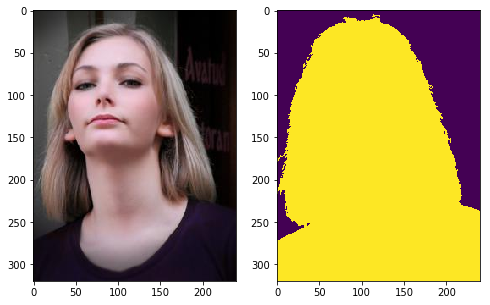

In [7]:
pict_visualise (train_df, 2, 'data/train/','data/train_mask/')

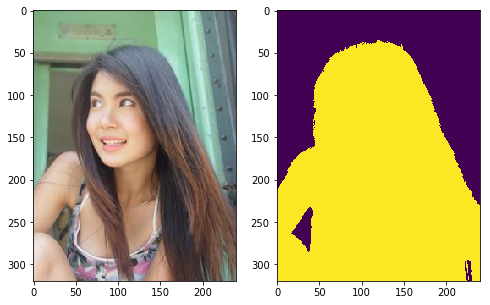

In [8]:
pict_visualise (valid_df, 2, 'data/valid/','data/valid_mask/')

# Создание генераторов, формирующих батчи из набора данных

Необходимоть введения данных функций обуславливается потребностью снизить нагрузку на оперативную память компьютера и не хранить в ней все файлы. Для этого применяеся yield.

In [9]:
train_generator(train_df, 16)

<generator object train_generator at 0x000001929DAE20C0>

In [10]:
# проверка точности расчетов
for x, y in valid_generator (valid_df, 16):
    break
print(x.shape, y.shape)

#### Проверим предположение о том, что у нас неравномерно распределен размер человека и фона на картинке

In [31]:
distribution = print(np.count_nonzero(y) / y.size)

0.518427848815918


## Строим модель UNet

In [13]:
# Библиотекой для разработки был выбран Keras
import keras
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D, Concatenate, Activation
from keras import backend as K

Using TensorFlow backend.


### базовая модель - ResNet50

In [14]:
def Unet_ResNet50 ():
    # Выбор предобученной модели из библиотеки
    base_model = ResNet50(weights='imagenet', input_shape=(256,256,3), include_top=False)
    base_out = base_model.output

    # Строим U-Net связи в модели:

# Определение тензоров необходимой размерности. Выбираются тенззоры на этапе активации.
    conv_1 = base_model.get_layer('activation_1').output
    conv_2 = base_model.get_layer('activation_10').output
    conv_3 = base_model.get_layer('activation_22').output
    conv_4 = base_model.get_layer('activation_40').output
    conv_5 = base_model.get_layer('activation_49').output

#     увеличиваем размер выбранного тензера
    up1 = UpSampling2D(2, interpolation='bilinear')(conv_5)
#     Сопоставление изображения и маски, противолежащих на нисходящей и восходящей сторонах слоев
    conc_1 = Concatenate()([up1, conv_4])
#     применение свертки без увеличения размера картинке для поиска полезной
#  информации
    conv_6 = Conv2D(256, (3, 3), padding='same')(conc_1)
#     функция активации
    conv_6 = Activation('relu')(conv_6)

# действия аналогичные предыдущей итерации
    up2 = UpSampling2D(2, interpolation='bilinear')(conv_6)
    conc_2 = Concatenate()([up2, conv_3])
    conv_7 = Conv2D(128, (3, 3), padding='same')(conc_2)
    conv_7 = Activation('relu')(conv_7)

    up3 = UpSampling2D(2, interpolation='bilinear')(conv_7)
    conc_3 = Concatenate()([up3, conv_2])
    conv_8 = Conv2D(64, (3, 3), padding='same')(conc_3)
    conv_8 = Activation('relu')(conv_8)

    up4 = UpSampling2D(2, interpolation='bilinear')(conv_8)
    conc_4 = Concatenate()([up4, conv_1])
    conv_9 = Conv2D(32, (3, 3), padding='same')(conc_4)
    conv_9 = Activation('relu')(conv_9)

    up5 = UpSampling2D(2, interpolation='bilinear')(conv_9)
    conv_10 = Conv2D(1, (3, 3), padding='same')(up5)
#     функция активации sigmoid, тк необходимо получить вероятности на последнем слое
    conv_10 = Activation('sigmoid')(conv_10)
    
    model = Model(input=base_model.input, output=conv_10)
    
    return model

In [15]:
model = Unet_ResNet50()

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\Aleksey\Anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '
C:\Users\Aleksey\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ac...)`


## Функции потерь, Метрика

In [17]:
# После каждой эпохи определяется лучший вес и последний вес. Best_w - сохраняет полную модель, Last_w - сохраняет 
# только веса. 
best_w = keras.callbacks.ModelCheckpoint('resnet_best.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=True,
                                save_weights_only=True,
                                mode='auto',
                                period=1)

last_w = keras.callbacks.ModelCheckpoint('resnet_last.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=True,
                                mode='auto',
                                period=1)


callbacks = [best_w, last_w]
adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss = weighted_bce_dice_loss, optimizer = adam, metrics = [my_iou_metric])

# размер батча выбран 4 как наиболее оптимальный для обучения на 1 GPU.
# количество эпох - 70, как показали различные варианты обучений, именно в районе 70 эпохи происходит переобучение 
# модели и качество на следующих эпохах медленно продолжает расти по train, но падает на valid
batch_size = 4
history = model.fit_generator(train_generator(train_df, batch_size),
              steps_per_epoch=100,
              epochs=70,
              verbose=1,
              callbacks=callbacks,
              validation_data=valid_generator(valid_df, batch_size),
              validation_steps=40,
              class_weight=None,
              max_queue_size=10,
              workers=1,
              use_multiprocessing=False,
              shuffle=True,
              initial_epoch=0)


Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    
Epoch 1/70
100/100 [==============================] - 57s 567ms/step - loss: 0.5782 - my_iou_metric: 0.6728 - val_loss: 0.4330 - val_my_iou_metric: 0.8275
Epoch 2/70
100/100 [==============================] - 43s 432ms/step - loss: 0.4046 - my_iou_metric: 0.7865 - val_loss: 0.3133 - val_my_iou_metric: 0.8744
Epoch 3/70
100/100 [==============================] - 44s 440ms/step - loss: 0.3291 - my_iou_metric: 0.8380 - val_loss: 0.2481 - val_my_iou_metric: 0.9144
Epoch 4/70
100/100 [==============================] - 45s 447ms/step - loss: 0.2680 - my_iou_metric: 

## Делаем прогноз:

In [18]:
# Подгрузим данные:
for list_of_img, list_of_mask, val_list, tests, test_list in import_data('data/valid/', 'data/valid_mask/', 'data/test/'):
    break

In [19]:
# предсказываем модель
pred_val = model.predict(val_list)

In [20]:
# Делаем ресайз назад и округляем предсказанные значения, приводя их к бинарному виду.
pred_val_list = []
for i in range (145):
    pred = cv2.resize(pred_val[i], (240, 320))
    pred_val_list.append(pred.round())

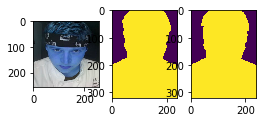

None 0


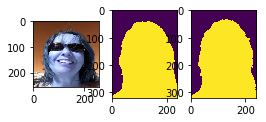

None 1


In [21]:
# Визуально cравним полученные маски
for im_id in range (2):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(4, 4))
    axes[0].imshow(list_of_img[im_id])
    axes[1].imshow(pred_val_list[im_id])
    axes[2].imshow(list_of_mask[im_id])

    print(plt.show(), im_id)

## Вычислим метрику ошибки:

In [22]:
get_dice(list_of_mask, pred_val_list)

0.9721206799009402

## Посмотрим динамику ошибки

In [23]:
from keras.callbacks import History 

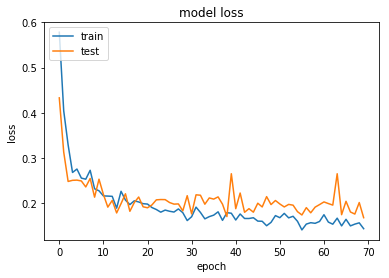

In [24]:
# график потерь
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

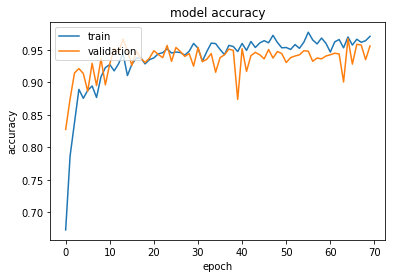

In [25]:
# график точность прогноза
plt.plot(history.history['my_iou_metric'])
plt.plot(history.history['val_my_iou_metric'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Как можно увидеть по графикам model accuracy, после 60 эпохи модель начинает разбалансироваться, основываясь на этих данных было выыбрано количество эпох в размере 70 штук, а также корректировалась вероятность применения аугментации к картинке (чем больше становиась вариация вариация между train и valid на поздни стадиях обучения, тем выше ставилась вероятность аугментации, тк было очевидно, что модель переобучается)

## Сохраним результаты validation

In [27]:
save_results(1315, 'data/pred_valid_template.csv', pred_val_list)

## Проведем проверку на тестовой выборке

In [28]:
pred_test = model.predict(test_list)

In [29]:
# Делаем ресайз назад
pred_list_tests = []
for i in range (100):
    pred = cv2.resize(pred_test[i], (240, 320))
    pred_list_tests.append(pred.round())
final_list_of_tests = np.array(pred_list_tests)

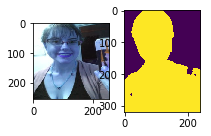

None 0


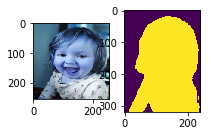

None 1


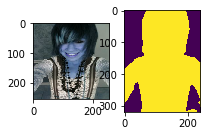

None 2


In [30]:
# Посмотрим значения
for im_id in range (3):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(3, 3))
    axes[0].imshow(test_list[im_id])
    axes[1].imshow(pred_list_tests[im_id])

    print(plt.show(), im_id)

#### На последнем шаге сохраняем полученные макси в html файл по образцу задания. (results/test.html)